# Classification of spoken digits

This is a great dataset, because there are so many different approaches you can take.

In [1]:
# load a single .wav file using librosa and return the audio time series and sampling rate
from scipy.io.wavfile import read

def load_audio_file(file_path):
    sr, data = read(file_path)
    return data, sr


In [29]:
example1, sampling_rate1 = load_audio_file('recordings/7_theo_36.wav')
example2, sampling_rate2 = load_audio_file('recordings/0_jackson_1.wav')
print(example1.shape, sampling_rate1)
print(example2.shape, sampling_rate2)


(17567,) 8000
(4261,) 8000


OK, so the sampling rates are the same, but the audio lengths are different...this is annoying, as most models require a fixed number of features. So we need to do some preprocessing to get some meaningful features. Let's look at an example:

In [30]:
# transform the audio time series into the frequency domain using the discrete Fourier transform
from scipy.fft import fft, fftfreq

def transform_audio_to_frequency_domain(audio, sampling_rate, n=4000):
    T = 1 / sampling_rate
    yf = fft(audio)
    xf = fftfreq(n, T)[:n//2]
    return xf, yf


xf1, yf1 = transform_audio_to_frequency_domain(example1, sampling_rate1)


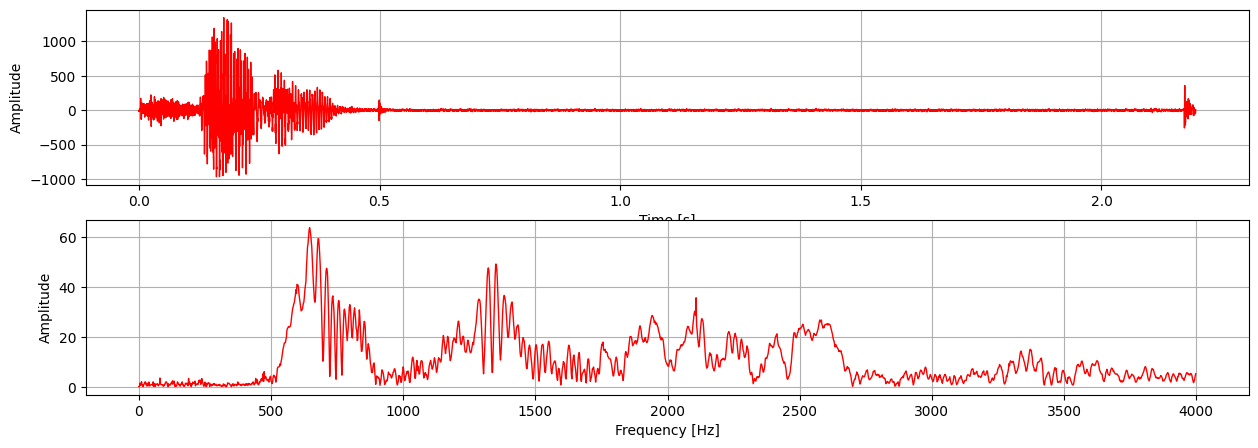

In [31]:
import matplotlib.pyplot as plt
import numpy as np

time = np.arange(0, len(example1)) / sampling_rate1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))
ax1.plot(time, example1, lw=1, color='r', label='Example 1')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude')

ax2.plot(xf1, 2.0 / 4000 * np.abs(yf1[:4000//2]), lw=1, color='r', label='Example 1')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude')

ax1.grid()
ax2.grid()
plt.show()

In [5]:
import os

def get_audio_time_series_lengths(folder_path):
    audio_time_series_lengths = []
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            audio, sampling_rate = load_audio_file(os.path.join(folder_path, file))
            audio_time_series_lengths.append(len(audio))
    return audio_time_series_lengths


audio_time_series_lengths = get_audio_time_series_lengths('recordings')

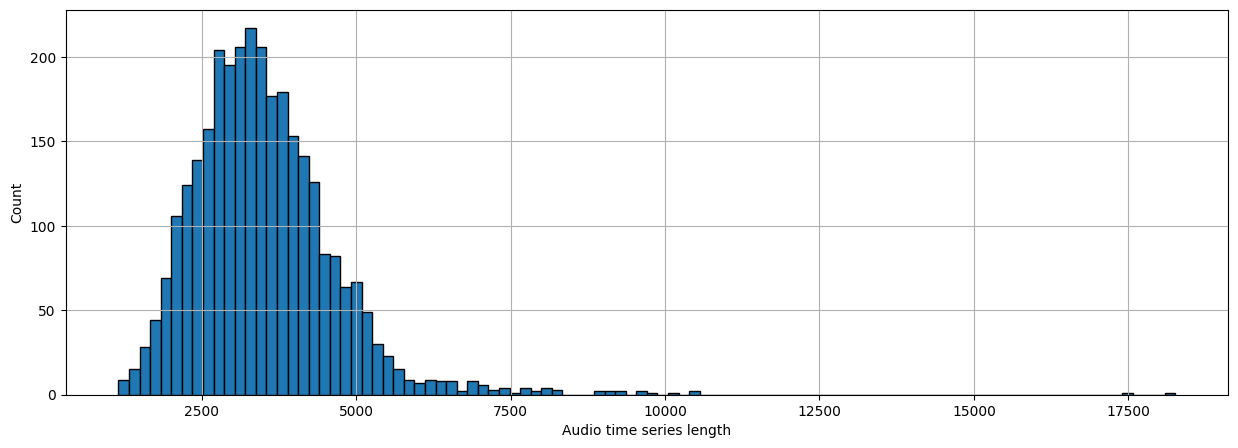

In [6]:
h, bins = np.histogram(audio_time_series_lengths, bins=100)

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(bins[:-1], h, width=np.diff(bins), ec="k", align="edge")
ax.set_xlabel('Audio time series length')
ax.set_ylabel('Count')
ax.grid()
plt.show()

There is useful information in both the time and frequency domain so let's use both by turning our samples into mel spectrograms. From here, we can collect summary statistics from the spectrograms: mean, standard deviation, min, max. We do this for each mel bin (each row in the spectrogram matrix.)

In [45]:
def generate_mel_spectrogram(audio, sample_rate):
    transform = MelSpectrogram(sample_rate, normalized=True)
    S = transform(torch.from_numpy(audio).type(torch.float))
    S = 10 * torch.log10(S)
    return S.numpy()

In [46]:
generate_mel_spectrogram(example1, 8000)

array([[ 5.9366965, 16.57009  , 12.725912 , ..., 17.248188 ,  5.7719855,
        25.379787 ],
       [15.868558 , 26.501951 , 22.657774 , ..., 27.18005  , 15.703846 ,
        35.31165  ],
       [11.8751   , 22.892097 , 22.80022  , ..., 26.390118 , -5.6840687,
        30.421246 ],
       ...,
       [30.381588 , 40.355526 , 43.666092 , ..., 16.151312 , 23.114374 ,
        21.279058 ],
       [24.128702 , 29.085098 , 31.105091 , ..., 15.826207 , 17.58123  ,
        16.931698 ],
       [20.528402 , 18.10911  , 20.432907 , ..., 13.138248 , 16.007067 ,
        17.426476 ]], dtype=float32)

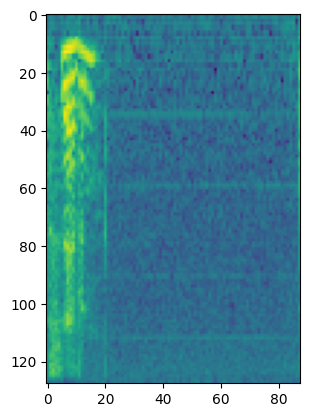

In [44]:
plt.imshow(S)

We now essentially want to generate a generic dataset, that we can use for some simple ML models. There are a few ways we can go about doing this:
- make a custom scikit-learn transformation that converts the dataset into spectrograms;
- make a custom class that reads from the folder, and converts the data.
- write a bunch of functions that read the audio and convert to spectrogram.

There's no right or wrong answer here, you're looking for the approach that is a balance between readability, computational complexity, time efficiency, and can be extended to other audio files.

What assumptions do we make? The sample rate is 8kHz - do we impose this on others so that they should also be using 8kHz sample rates?

Let's get started. We already have a function that loads an audio file, and a function that generates a spectrogram from an audio. Now we write a function that does this for every audio file in a folder and saves the results to a data structure.

In [8]:
log_S1.shape

(128, 138)

In [9]:
def summary_statistics(spectrogram : np.ndarray):
    mean = spectrogram.mean(axis=1)
    std = spectrogram.std(axis=1)
    stats = np.concatenate([mean, std])

    return stats


def get_data(folder_path):
    labels = []
    data = []
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            # Get spectrogram and summary statistics
            audio, sampling_rate = load_audio_file(os.path.join(folder_path, file))
            log_S = generate_mel_spectrogram(audio, sampling_rate)
            stats = summary_statistics(log_S)
            data.append(stats)

            # Get labels
            label = int(file[:1])
            labels.append(label)

    return np.array(data), np.array(labels)

In [10]:
data, labels = get_data('recordings')

So now we have some data and some labels. Let's try the same pipeline as we used in Lab 2.

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [12]:
# Test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1337)
print(y_train.shape, y_val.shape, y_test.shape)

(1687,) (563,) (750,)


In [13]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

estimator = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA(n_components=2)),
    ("classifier", KNeighborsClassifier())
])

estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")

Accuracy: 0.25


In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=1337)

param_grid = {
    "pca__n_components": np.arange(1, 48),
    "classifier__n_neighbors": np.arange(1, 48)
}

estimator = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA()),
    ("classifier", KNeighborsClassifier())
])

# clf = RandomizedSearchCV(estimator, param_grid, n_iter=10000, cv=5, verbose=1, n_jobs=-1)
clf = GridSearchCV(estimator, param_grid, cv=5, verbose=1, n_jobs=-1)
search = clf.fit(X_train, y_train)

Fitting 5 folds for each of 2209 candidates, totalling 11045 fits


In [30]:
print(f"Best parameters: {search.best_params_}")

Best parameters: {'classifier__n_neighbors': 1, 'pca__n_components': 45}


In [22]:
search.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=41)),
                ('classifier', KNeighborsClassifier(n_neighbors=1))])

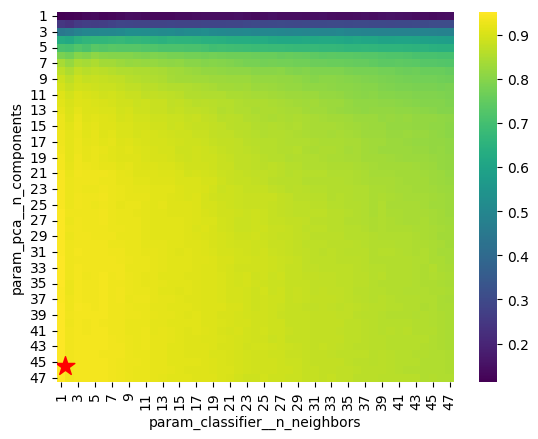

In [31]:
# plot heatmap of the validation accuracy as a function of n_components and n_neighbors
import pandas as pd

df = pd.DataFrame(search.cv_results_)

import seaborn as sns

sns.heatmap(df.pivot_table(index="param_pca__n_components", columns="param_classifier__n_neighbors", values="mean_test_score"),fmt=".3f", cmap="viridis")
plt.scatter(search.best_params_["classifier__n_neighbors"], search.best_params_["pca__n_components"], marker="*", s=200, c="r")

In [21]:
# Best model
y_pred = search.best_estimator_.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.96


OK, great. Our initial model works pretty well. But think about what else we can optimize here. There are other hyperparamters that might play a role, namely the `n_mels`, `hop_length`, and `n_fft`. It might be useful to write a custom transformation class that will allow us to alter these hyperparameters.

We have a number of functions that we have written that we can combine into a cutom data transformation class. Consider what we want as the starting point - we don't need to read any files, so that can remain separated, we just need to create spectrograms. So X is now no longer a numpy array, but a list of audio streams.

In [15]:
from numpy import ndarray
from sklearn.base import BaseEstimator, TransformerMixin

class SummaryStats(BaseEstimator, TransformerMixin):
    def __init__(self, sr=4000, n_fft=1024, hop_length=128, n_mels=128):
        super().__init__()
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = []
        for x in X:
            # Get spectrogram and summary statistics
            log_S = self.generate_mel_spectrogram(x, self.sr, self.n_fft, self.hop_length, self.n_mels)
            stats = self.summary_statistics(log_S)
            data.append(stats)
        return np.array(data)

    def generate_mel_spectrogram(self, audio, sr, n_fft=1024, hop_length=128, n_mels=128):
        S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        log_S = librosa.power_to_db(S, ref=np.max)
        return log_S
    
    def summary_statistics(self, spectrogram : np.ndarray):
        mean = spectrogram.mean(axis=1)
        std = spectrogram.std(axis=1)
        stats = np.concatenate([mean, std])

        return stats

But we now need to modify how we read our data from the folder and collect labels. Take a minute and see if you can do this by yourself in the cell below: 

In [16]:
def get_data(folder_path):
    labels = []
    audio_data = []
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            # Get spectrogram and summary statistics
            audio, _ = load_audio_file(os.path.join(folder_path, file))
            audio_data.append(audio)

            # Get labels
            label = int(file[:1])
            labels.append(label)

    return audio_data, np.array(labels)

data, labels = get_data('recordings')

In [41]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=1337)

param_grid = {
    "summary_stats__n_mels" : np.array([64, 128]),
    "pca__n_components" : np.arange(32, 48),
    "classifier__n_neighbors" : np.arange(32, 48)
}

estimator = Pipeline([
    ("summary_stats", SummaryStats(sr=4000, n_fft=1024, hop_length=128, n_mels=128)),
    ("scaler", MinMaxScaler()),
    ("pca", PCA(n_components=2)),
    ("classifier", KNeighborsClassifier())
])

# clf = RandomizedSearchCV(estimator, param_grid, n_iter=10000, cv=5, verbose=1, n_jobs=-1)
# clf = GridSearchCV(estimator, param_grid, cv=5, verbose=1, n_jobs=-1)
search = estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

/Users/rkd/Pipelines/AutumnSchool/venv/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=256
  warnings.warn(
/Users/rkd/Pipelines/AutumnSchool/venv/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=256
  warnings.warn(


Accuracy: 0.24


Now we have a class that will do this tranformation for us. And what about if we just want to assess a single audio file, and make a prediction? Can we do this? Hint: the answer is yes.

So we've tried our model, it works well, and now we have this extra layer of complexity, and things are starting to get a bit out of control. We have so many moving parts, it's hard to keep track of everything, and how do I really know that things are working correctly...

It's time to level up, and transfer this stuff to a script so that we can process, train, optimize, and infer, in a much more automatic fashion.